In [10]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]
from IPython import display
%matplotlib inline
import gymnasium as gym
import torch
import time


In [4]:
from PIL import Image
import numpy as np
def display_image(imageArray):
    display.display(Image.fromarray(np.array(imageArray),'RGB'),clear=True)

In [13]:
from collections import namedtuple
Tr  = namedtuple('Transition', ('state','action', 'next_state','reward'))

In [5]:
NUM_DIZITIZED = 6
def reset(env):
      observation = env.reset()[0]
      s_a_history = [[observation, np.nan]]
      pi = [0.5,0.5]
      return observation, s_a_history, pi
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))
    ]
    return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

def get_action(s,Q,epsilon, pi=[0.5,0.5]):
    state = digitize_state(s)
    if np.random.rand() < epsilon:
        action = np.random.choice([0,1])
    else:
        action = np.argmax(Q[state])
    return action

def Q_learning(s, a, r, s_next, Q, eta, gamma, is_terminated):
    s = digitize_state(s)
    s_next = digitize_state(s_next)
    if is_terminated:
        Q[s, a] = Q[s, a] + eta * (r- Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
    return Q

def run_once(env, s_a_history,initial_observation, Q, epsilon, eta, gamma, pi, show=False):
    observation = initial_observation
    s = observation
    a = get_action(s, Q, epsilon, pi)
    a_next = a
    count = 0;
    while True:
        is_terminated = False
        if show:
            time.sleep(0.01)
            img = env.render()
            display_image(img)
        a = a_next
        s_a_history[-1][1] = a
        s_next, reward, terminated, truncated, info = env.step(a)
        s_a_history.append([s_next, np.nan])
        if count > 500:
            r = 1
            a_next = np.nan
            is_terminated = True
        elif count < 500 and terminated:
            r = -1
            a_next = np.nan
            is_terminated = True
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma, is_terminated)
        if is_terminated:
            if show:
                time.sleep(0.01)
                img = env.render()
                display_image(img)
            break
        else:
            s = s_next
        count += 1
    return [s_a_history, Q]

In [8]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
eta = 0.1
gamma = 0.9
epsilon = 0.5
Q = np.random.rand(NUM_DIZITIZED**4,2)
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1
env.reset()
while is_continue:
    observation, s_a_history, pi = reset(env)
    #print('episode: ' + str(episode))
    epsilon = epsilon / 2
    [s_a_history, Q] = run_once(env, s_a_history, observation, Q, epsilon, eta, gamma, pi,show=False)
    new_v = np.nanmax(Q, axis=1)
    #print(np.sum(np.abs(new_v - v)))
    v = new_v
    episode = episode + 1
    if episode > 1000:
        break
print(np.sum(np.abs(new_v - v)))
env.close()

0.0


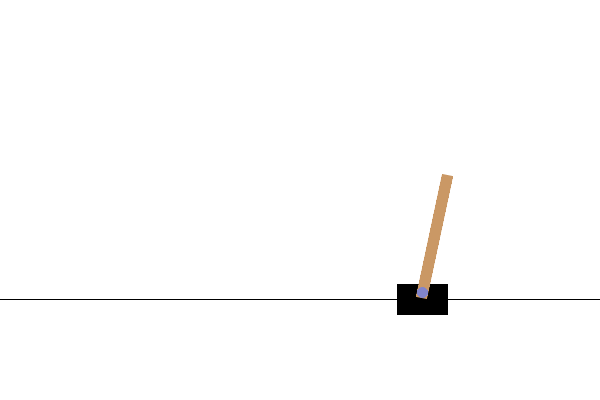

[[[array([ 0.00255501,  0.0484085 , -0.02896351,  0.03017939], dtype=float32),
   0],
  [array([ 0.00352318, -0.14628638, -0.02835992,  0.31358513], dtype=float32),
   0],
  [array([ 0.00059745, -0.3409931 , -0.02208822,  0.5971911 ], dtype=float32),
   0],
  [array([-0.00622241, -0.5357991 , -0.0101444 ,  0.8828354 ], dtype=float32),
   1],
  [array([-0.01693839, -0.34054086,  0.00751231,  0.5869807 ], dtype=float32),
   1],
  [array([-0.02374921, -0.14552492,  0.01925192,  0.29667366], dtype=float32),
   1],
  [array([-0.02665971,  0.04931737,  0.0251854 ,  0.01012409], dtype=float32),
   1],
  [array([-0.02567336,  0.24406925,  0.02538788, -0.27450734], dtype=float32),
   0],
  [array([-0.02079197,  0.04859443,  0.01989773,  0.0260736 ], dtype=float32),
   1],
  [array([-0.01982009,  0.24342546,  0.0204192 , -0.26026556], dtype=float32),
   0],
  [array([-0.01495158,  0.04801806,  0.01521389,  0.03878728], dtype=float32),
   1],
  [array([-0.01399122,  0.24291858,  0.01598964, -0.24

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env.reset()
observation, s_a_history, pi = reset(env)
run_once(env, s_a_history, observation, Q, 0, eta, gamma, pi,show=True)